## Задание

### Текст задания:
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import requests
from urllib.parse import urlencode

### Загружаем данные и проводим предобработку

In [2]:
def get_data_from_Yandex_disk(url, sep):
    """ 
    Возвращает df из файла с .csv-расширением, хранящегося на Яндекс-диске,
    url - путь на Яндекс-диск,
    sep - разделитель в файле csv
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
       
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    df = pd.read_csv(download_url, sep=sep)
    return df

In [3]:
auth_data = get_data_from_Yandex_disk('https://disk.yandex.ru/d/KLGQxujRmAc3dQ', sep=';')

##### Приводим даты в нужный формат.

In [4]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
auth_data.shape

(9601013, 2)

In [6]:
auth_data.uid.value_counts()

2          1929
108        1397
158        1367
176        1331
191        1296
           ... 
420829        1
420830        1
420832        1
420835        1
1110622       1
Name: uid, Length: 1000000, dtype: int64

In [7]:
auth_data.uid.nunique()

1000000

In [8]:
auth_data['auth_ts'] = auth_data['auth_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

In [9]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], format='%Y-%m-%d')

In [10]:
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [11]:
reg_data = get_data_from_Yandex_disk('https://disk.yandex.ru/d/V38QVEg9ioeAyg', sep=';')

In [12]:
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [13]:
reg_data['reg_ts'] = reg_data['reg_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

In [14]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], format='%Y-%m-%d')

In [15]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

### Объединяем данные в одну таблицу и отбираем за последние 2 недели
т.к. более ранние данные в контексте нашей задачи уже потеряли актуальность

In [16]:
all_data = auth_data.merge(reg_data, how='left', on='uid', copy=True)

In [17]:
data_for_analysis = all_data.query('reg_ts >= "2020-09-10"')

### Когортный анализ / Визуализация

In [18]:
def Cohort_analysis(df):
    # отфильтруем массив так, чтобы визуально контролировать правильность дальнейших действий
    df.sort_values(['uid', 'auth_ts'], inplace=True)
    
    # Сначала расчитаем добавим дату первой авторизации в df
    first_auth = df.groupby('uid', as_index=False) \
                   .agg({'auth_ts': 'min'}) \
                   .rename(columns={'auth_ts': 'first_auth'})
    data_for_analysis_merged = df.merge(first_auth, how='left', on='uid')
    # Переименуем колонки для удобства
    data_for_analysis_merged.rename(columns={'auth_ts': 'authorisation_date', 'reg_ts': 'regist_date'}, inplace=True)
    
    # Строим когорты. Когорты - игроки, сделавшие первую авторизацию в тот или иной день. 
    # Целевая метрика - количество авторизаций 
    cohorts = data_for_analysis_merged.groupby(['regist_date', 'authorisation_date'], as_index=False) \
                                      .agg({'uid': 'nunique', 
                                            'first_auth': 'count'}) \
                                      .rename(columns={'uid': 'total_users',
                                                       'first_auth': 'total_first_auth'})
    # Считаем период
    cohorts['cohort_period'] = cohorts.authorisation_date - cohorts.regist_date
    
    # считаем retention
    # сначала переиндексируем df и создадим ряд содержаший размер каждой когорты regist_date
    cohorts.set_index(['cohort_period', 'regist_date'], inplace=True)
    cohort_group_size = cohorts['total_users'].groupby(level=1).first()
    
    user_ret = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=0)
    
    # Блок визуелизации
    sns.set(style='ticks')
    plt.figure(figsize=(24, 16))
    plt.title('Cohorts: User Retention')
    plt.xlabel('Cohort Period')
    plt.ylabel('Date of registration')
 
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   # labels for x-axis
    y = cohorts.reset_index().regist_date.dt.strftime('%m/%d/%Y').unique()   # labels for y-axis

    sns.heatmap(user_ret, 
                mask=user_ret.isnull(), 
                annot=True, 
                fmt='.0%', 
                linewidths=.5,
                cmap="YlGnBu",
                vmin=0,
                vmax=0.2,
                xticklabels=x,
                yticklabels=y)
          
    return user_ret

C:\Users\Nata\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


cohort_period,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,11 days,12 days,13 days
regist_date,,,,,,,,,,,,,,
2020-09-10,1.0,0.013673,0.044127,0.051585,0.049720,0.064636,0.062772,0.062150,0.054071,0.041019,0.058421,0.050963,0.049099,0.039776
2020-09-11,1.0,0.013656,0.038485,0.039106,0.057728,0.063315,0.073867,0.057107,0.043451,0.044693,0.051521,0.063315,0.043451,NaN
2020-09-12,1.0,0.018587,0.042751,0.043990,0.039653,0.062577,0.069393,0.060099,0.050186,0.048327,0.048327,0.034696,NaN,NaN
2020-09-13,1.0,0.022277,0.043936,0.040223,0.052599,0.062500,0.068688,0.050124,0.052599,0.051980,0.052599,NaN,NaN,NaN
2020-09-14,1.0,0.017901,0.036420,0.037654,0.056173,0.059877,0.067284,0.066667,0.040123,0.037654,NaN,NaN,NaN,NaN
2020-09-15,1.0,0.023428,0.045006,0.040691,0.063502,0.054871,0.070284,0.056104,0.035142,NaN,NaN,NaN,NaN,NaN
2020-09-16,1.0,0.022167,0.043103,0.043719,0.052956,0.066502,0.078202,0.040640,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-17,1.0,0.020270,0.038084,0.040541,0.058354,0.055283,0.060811,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-18,1.0,0.021472,0.039877,0.044172,0.046012,0.054601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


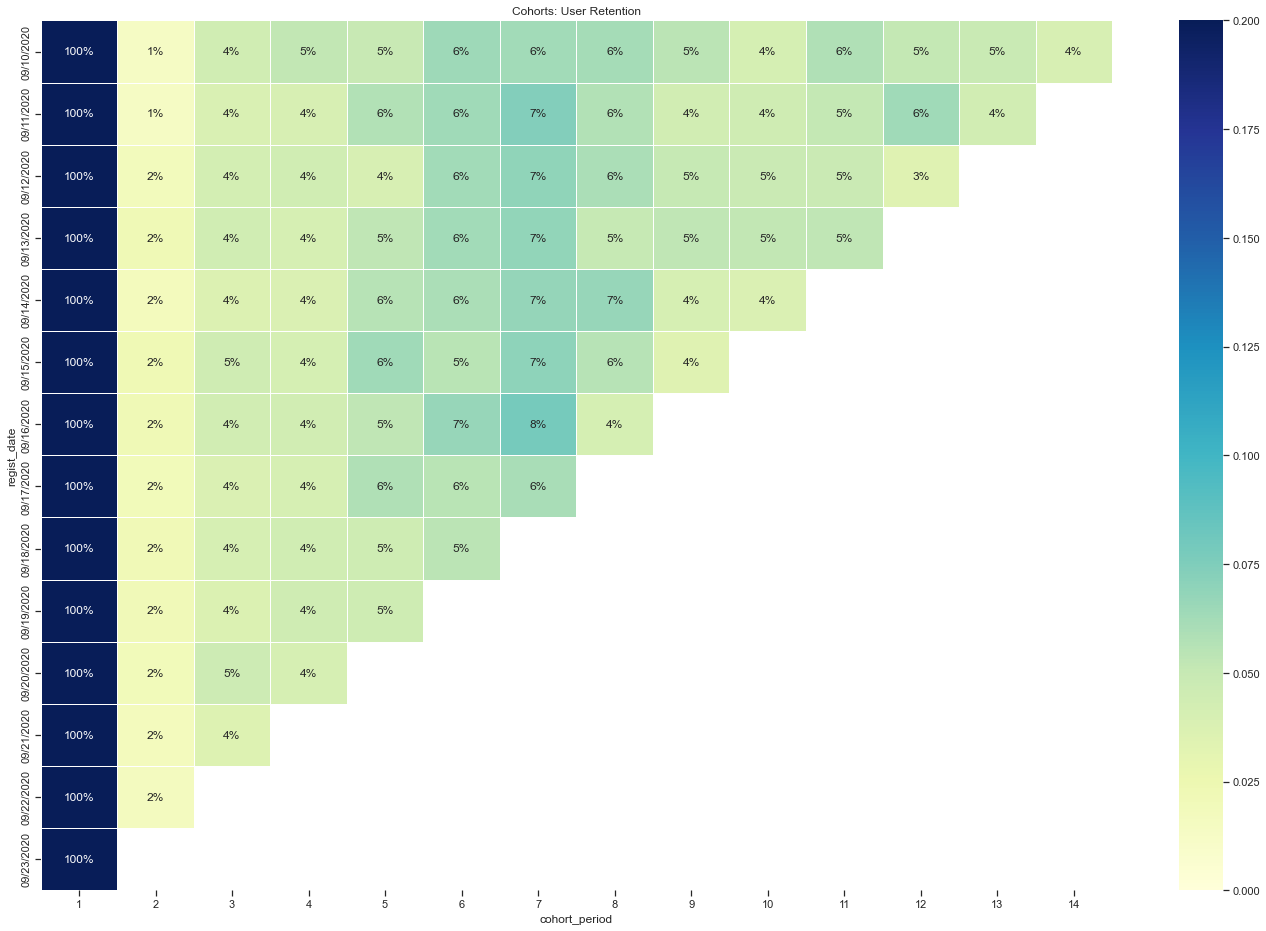

In [19]:
Cohort_analysis(data_for_analysis)

## Задание 2

### Текст задания:
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

1. Эффективность проведения тематического события можно оценить исходя из следующих метрик:
   - ASD (Average Session Duration). Эта метрика покажет нам, насколько изменилось среднее время, проведенное в игре до проведения события и после. Если событие было интересным, то ASD увеличится;
   - ATV (Average Transaction Value) - средний чек. Для прохождение доролнительных событий в игре по-прежнему будут необходимы жизни или иные ограниченные ресурсы, которые можно приобрести. Поэтому средний чек может вырасти
   - Stickness rate (Залипательность игры). Рассчитывается как DAU/MAU. Таким образом, мы сможем узнать, насколько тематическое событие способствует сохранению аудитории.
   - CR в покупку. По тем же присинам, которые могут привести к увеличению ATV, может вырасти и CR. Новое событие может подтолкнуть новых пользователей к первой покупке. А постоянных пользователей к повторой покупке.
   - Retention rate. 
   - Churn rate. Помимо отслеживания "позитивных" метрик, нам необходимо убедиться, что рост финансовых метрик не происходит на фоне увеличения процента "выгоревших" пользователей. Это может происходить, если задания слишком сложные и теряется мотивация в их прохождении, что в целом влечет за собой снижение лояльности игре.

2. В случае усложнения механики, особенно важно смотреть на Churn rate и ASD на равне с финансовыми метриками, т.к. усложнение заданий может снизить желание пользователя играть. Но набор метрик, на мой взгляд, остается, в целом, тем же. 